In [1]:
import dataclasses
import functools

import jax
from jax import numpy as jnp
import numpy as np

from flax import linen
from flax import struct
import optax
from tensorflow_probability.substrates import jax as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

from brax import envs as brax_envs
from matplotlib import pylab as plt

import daves_rl_lib
from daves_rl_lib import networks
from daves_rl_lib.algorithms import advantage_actor_critic
from daves_rl_lib.environments import environment_lib
from daves_rl_lib.internal import util

In [2]:
batch_size = 256
discount_factor = 0.999
entropy_regularization = 0.2

In [3]:
brax_env = brax_envs.create('inverted_pendulum', episode_length=500)

# Wrap environment to terminate if the cart goes out of bounds (like OpenAI
# gym's cartpole).
original_step = brax_env.step
def step_with_pos_check(state, action, bound=4.):
    new_state = original_step(state, action)
    return dataclasses.replace(new_state,
                               done=jnp.logical_or(
                                   new_state.done,
                                   jnp.abs(new_state.obs[..., 0]) > bound))
brax_env.step = step_with_pos_check

# Work around tracer conversion errors (potential brax bug).
brax_env.reset = jax.jit(brax_env.reset)
brax_env.step = jax.jit(brax_env.step)

env = environment_lib.BRAXEnvironment(
    brax_env,
    discount_factor=discount_factor)

In [4]:
# Categorical policy produces output vectors [-1.] or [1.].
def categorical_vector_from_logits(logits):
    cat = tfp.distributions.Categorical(logits=logits, dtype=logits.dtype)
    dist = tfp.bijectors.Chain([
        tfp.bijectors.Reshape(event_shape_out=[1], event_shape_in=[]),
        tfp.bijectors.Shift(-1.),
        tfp.bijectors.Scale(2.)])(cat)
    dist.entropy = cat.entropy
    return dist
policy_net = networks.make_model(
            [24, 24, 2],
            obs_size=env.observation_size,
            activate_final=categorical_vector_from_logits)
value_net = networks.make_model([24, 24, 1], obs_size=env.observation_size)
policy_optimizer = optax.adam(1e-2)
value_optimizer = optax.adam(3e-2)

In [5]:
learner = advantage_actor_critic.initialize_learner(
    env,
    policy_net=policy_net,
    value_net=value_net,
    policy_optimizer=policy_optimizer,
    value_optimizer=value_optimizer,
    batch_size=batch_size,
    seed=jax.random.PRNGKey(0))

In [6]:
initial_observations = learner.agent_states.observation
dangerous_states = initial_observations + jnp.array([3.9, 0., 0., 0.])

initial_values = value_net.apply(learner.value_weights, initial_observations)
dangerous_state_values = value_net.apply(learner.value_weights, dangerous_states)

print("Prior to training:")
print("Values of initial states:", util.format_summary(initial_values))
print("Values of 'dangerous' states:", util.format_summary(dangerous_state_values))

Prior to training:
Values of initial states: SummaryStats(mean='-7.008122e-05', std='0.0011687946', median='-0.00015081065', min='-0.0023938469', max='0.0022543988')
Values of 'dangerous' states: SummaryStats(mean='-0.7876178', std='0.0021179176', median='-0.78741205', min='-0.79262817', max='-0.7829718')


In [7]:
def trace_episode_length_and_reward(
        tq: advantage_actor_critic.A2CTraceableQuantities):
    return {
        'advantage': tq.advantage,
        'state_values': tq.state_values,
        'returns': tq.returns,
        'reward-to-go': tq.reward_to_go,
        'done': jnp.array(tq.agent_states.done, dtype=bool),
        'episode_return': tq.agent_states.episode_return,
        'num_steps': tq.agent_states.num_steps,
        'qp': tq.agent_states.unobserved,
        'policy_entropy': tq.policy_entropy
    }

num_steps = 20
step_fn = advantage_actor_critic.make_advantage_actor_critic_batch_step(
    env=env,
    policy_net=policy_net,
    value_net=value_net,
    policy_optimizer=policy_optimizer,
    value_optimizer=value_optimizer,
    num_steps=num_steps,
    entropy_regularization=entropy_regularization,
    trace_fn=trace_episode_length_and_reward)

jit_step_fn = jax.jit(step_fn)

In [8]:
learner, diagnostics = jax.lax.scan(jit_step_fn, learner, jnp.arange(500))

In [9]:
initial_values = value_net.apply(learner.value_weights, initial_observations)
dangerous_state_values = value_net.apply(learner.value_weights, dangerous_states)

print("After training:")
print("Values of initial states:", util.format_summary(initial_values))
print("Values of 'dangerous' states:", util.format_summary(dangerous_state_values))

After training:
Values of initial states: SummaryStats(mean='208.17322', std='0.42798945', median='208.12753', min='207.47363', max='208.90823')
Values of 'dangerous' states: SummaryStats(mean='185.14043', std='0.71076614', median='185.05765', min='183.94926', max='186.41136')


In [10]:
policy_entropies = diagnostics.pop('policy_entropy')
flat_diagnostics = jax.tree_util.tree_map(
    functools.partial(advantage_actor_critic.concatenate_diagnostic_steps,
                      num_steps=num_steps),
    diagnostics)
jax.tree_util.tree_map(lambda x: x.shape, flat_diagnostics)

{'advantage': (256, 10000),
 'done': (256, 10000),
 'episode_return': (256, 10000),
 'num_steps': (256, 10000),
 'qp': QP(pos=(256, 10000, 2, 3), rot=(256, 10000, 2, 4), vel=(256, 10000, 2, 3), ang=(256, 10000, 2, 3)),
 'returns': (256, 10000),
 'reward-to-go': (256, 10000),
 'state_values': (256, 10000)}

Text(0.5, 1.0, 'Mean policy entropy')

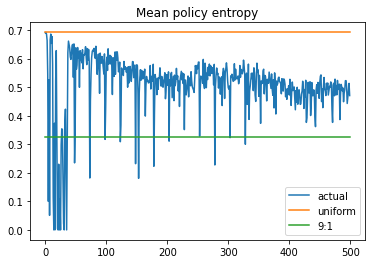

In [11]:
render_batch_idx = 0

plt.plot(policy_entropies[:, render_batch_idx], label='actual')
plt.plot(jnp.ones(policy_entropies.shape[:1]) * jnp.log(2), label='uniform')
plt.plot(jnp.ones(policy_entropies.shape[:1]) * -(0.9 * jnp.log(0.9) + 0.1 * jnp.log(0.1)), label='9:1')
plt.legend()
plt.title('Mean policy entropy')

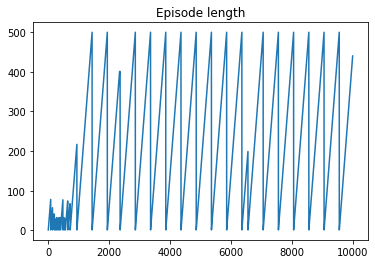

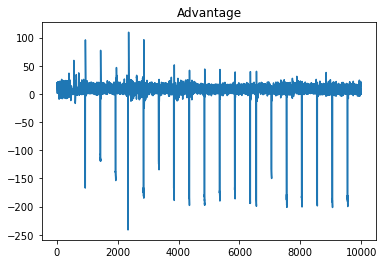

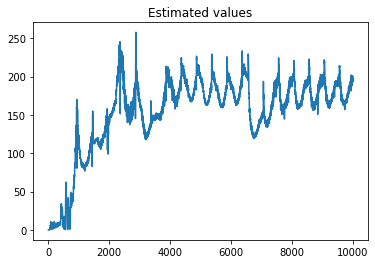

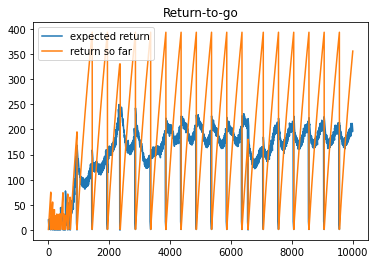

In [12]:

render_batch_idx = 2

plt.plot(flat_diagnostics['num_steps'][render_batch_idx])
plt.title('Episode length')
plt.figure()
plt.plot(flat_diagnostics['advantage'][render_batch_idx])
plt.title('Advantage')
plt.figure()
plt.plot(flat_diagnostics['state_values'][render_batch_idx])
plt.title('Estimated values')
plt.figure()
plt.plot(flat_diagnostics['returns'][render_batch_idx], label='expected return')
plt.plot(flat_diagnostics['episode_return'][render_batch_idx], label='return so far')
plt.title('Return-to-go')
plt.legend()


In [15]:
from IPython import display
from brax.io import html as brax_html
from brax.io import image as brax_image

num_steps = flat_diagnostics['done'].shape[1]

d = None
if False:  # Renders slow down VSCode so only do it if explicitly requested.
    qps = [jax.tree_util.tree_map(lambda x: x[render_batch_idx, t, ...],
                              flat_diagnostics['qp'])
       for t in range(num_steps - 1000, num_steps)]
    d = display.HTML(
        brax_html.render(env._brax_env.sys, qps))
d